In [1]:
import os
import librosa
import pickle
import sklearn
import numpy
import time

In [2]:
def create_database(n_mfcc_list, class_size):
    train_audio_path = 'data/train/audio'
    commands = os.listdir(train_audio_path)[:-1]
    classes = []
    samples = dict.fromkeys(n_mfcc_list, [])
    labels = dict.fromkeys(n_mfcc_list, [])
    print("Databases generation in progress:")
    command_cnt = 0
    start = time.time()
    for command in commands:
        classes.append(command)
        command_cnt += 1
        sample_num = 0
        print(f'                                          ', end='\r')
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            delta = time.time() - start
            samples_done_number = (((command_cnt-1)*class_size)+sample_num)
            samples_remain_number = (len(commands)*class_size) - samples_done_number
            rt = delta/samples_done_number*samples_remain_number
            print(f'{command_cnt}/{len(commands)} -> {command}: {sample_num/class_size*100:.0f}%  RT: {rt:.3f}s', end='\r')
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            for n_mfcc in n_mfcc_list:
                mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
                mean_mfcc_seq = []
                for feature in mfcc_seq:
                    mean_mfcc_seq.append(numpy.mean(feature))
                samples[n_mfcc] = samples[n_mfcc] + [mean_mfcc_seq]
                labels[n_mfcc] = labels[n_mfcc] + [command]
            if sample_num == class_size:
                break
    print("\nGeneration finished!\n")
    return classes, samples, labels

In [3]:
def train_model(train_size, test_size, k, classes, samples, labels):
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for classname in classes:
        train_size_index = 0
        test_size_index = 0
        for i in range(len(labels)):
            if labels[i] == classname and train_size_index < train_size:
                train_samples.append(samples[i])
                train_labels.append(labels[i])
                train_size_index += 1
            elif labels[i] == classname and test_size_index < test_size:
                test_samples.append(samples[i])
                test_labels.append(labels[i])
                test_size_index += 1
            if train_size_index == train_size and test_size_index == test_size:
                break

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_samples, train_labels)

    predicted_labels = classifier.predict(test_samples)

    # print('Test  :  Predicted')
    # for i in range(min(len(test_labels),len(predicted_labels))):
    #     print(f'{test_labels[i]:5} :  {predicted_labels[i]:5}')

    # print(test_labels == predicted_labels)
    quality = numpy.sum(test_labels == predicted_labels) / len(test_labels) * 100;
    return quality

In [30]:
from matplotlib import pyplot as plt

def check_quality(n_mfcc, train_size, k, database):
    quality_list = []
    print("Reading database...")
    classes, samples_dct, labels_dct = database
    quality = train_model(train_size, 10, k, classes, samples_dct[n_mfcc], labels_dct[n_mfcc])
    return quality

In [5]:
def find_optimal_n_mfcc(n_mfcc_list, class_size):
    quality_list = []
    print("Creating database...")
    classes, samples_dct, labels_dct = create_database(n_mfcc_list, class_size)
    for n_mfcc in n_mfcc_list:
        print("N_MFCC = " + str(n_mfcc))
        quality = train_model(40, 10, 5, classes, samples_dct[n_mfcc], labels_dct[n_mfcc])
        quality_list.append(quality)
        print("\n")
    plt.figure(figsize=(14,5))
    plt.plot(n_mfcc_list, quality_list,'bo-')
    plt.title("Zależność oceny klasyfikatora od wpółczynnika n_mfcc")
    plt.xlabel("n_mfcc")
    plt.ylabel("Quality")
    plt.grid()
    plt.show()
    return n_mfcc_list[quality_list.index(max(quality_list))]

In [6]:
def find_optimal_train_size(n_mfcc, train_size_list, database):
    quality_list = []
    print("Reading database...")
    classes, samples_dct, labels_dct = database
    for train_size in train_size_list:
        print("TRAIN_SIZE = " + str(train_size))
        quality = train_model(train_size, 10, 5, classes, samples_dct[n_mfcc], labels_dct[n_mfcc])
        quality_list.append(quality)
        print("\n")
    plt.figure(figsize=(14,5))
    plt.plot(train_size_list, quality_list,'ro-')
    plt.title("Zależność oceny klasyfikatora od wielkości zbioru treningowego")
    plt.xlabel("train_size")
    plt.ylabel("Quality")
    plt.grid()
    plt.show()
    return train_size_list[quality_list.index(max(quality_list))]

In [7]:
def find_optimal_k(n_mfcc, optimal_train_size, k_list, database):
    quality_list = []
    print("Reading database...")
    classes, samples_dct, labels_dct = database
    for k in k_list:
        print("K = " + str(k))
        quality = train_model(optimal_train_size, 10, k, classes, samples_dct[n_mfcc], labels_dct[n_mfcc])
        quality_list.append(quality)
        print("\n")
    plt.figure(figsize=(14,5))
    plt.plot(k_list, quality_list,'go-')
    plt.title("Zależność oceny klasyfikatora od parametru k")
    plt.xlabel("k")
    plt.ylabel("Quality")
    plt.grid()
    plt.show()
    return k_list[quality_list.index(max(quality_list))]

Creating database...
Databases generation in progress:
30/30 -> zero: 100%  RT: 0.000s           
Generation finished!

N_MFCC = 1


N_MFCC = 2


N_MFCC = 3


N_MFCC = 4


N_MFCC = 5


N_MFCC = 6


N_MFCC = 7


N_MFCC = 8


N_MFCC = 9


N_MFCC = 10


N_MFCC = 11


N_MFCC = 12


N_MFCC = 13


N_MFCC = 14


N_MFCC = 15


N_MFCC = 16


N_MFCC = 17


N_MFCC = 18


N_MFCC = 19


N_MFCC = 20


N_MFCC = 21


N_MFCC = 22


N_MFCC = 23


N_MFCC = 24


N_MFCC = 25


N_MFCC = 26


N_MFCC = 27


N_MFCC = 28


N_MFCC = 29


N_MFCC = 30


N_MFCC = 31


N_MFCC = 32


N_MFCC = 33


N_MFCC = 34


N_MFCC = 35


N_MFCC = 36


N_MFCC = 37


N_MFCC = 38


N_MFCC = 39


N_MFCC = 40


N_MFCC = 41


N_MFCC = 42


N_MFCC = 43


N_MFCC = 44


N_MFCC = 45


N_MFCC = 46


N_MFCC = 47


N_MFCC = 48


N_MFCC = 49


N_MFCC = 50


N_MFCC = 51


N_MFCC = 52


N_MFCC = 53


N_MFCC = 54


N_MFCC = 55


N_MFCC = 56


N_MFCC = 57


N_MFCC = 58


N_MFCC = 59


N_MFCC = 60


N_MFCC = 61


N_MFCC = 62


N_MFCC = 63


N_MFCC 

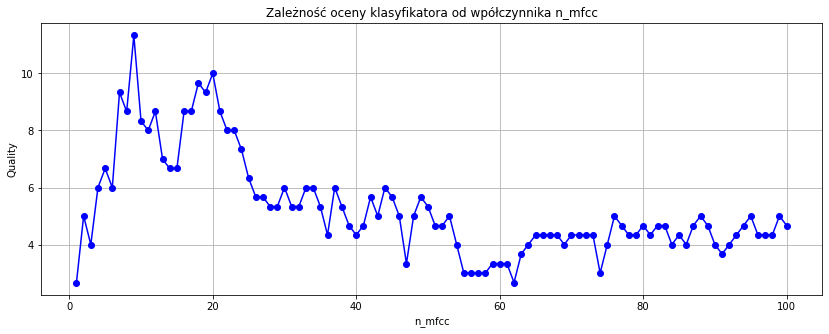

9


In [8]:
optimal_n_mfcc = find_optimal_n_mfcc(range(1,101), 60)
print(optimal_n_mfcc)

Databases generation in progress:
30/30 -> zero: 100%  RT: 0.000s           
Generation finished!

Reading database...
TRAIN_SIZE = 4


TRAIN_SIZE = 5


TRAIN_SIZE = 6


TRAIN_SIZE = 7


TRAIN_SIZE = 8


TRAIN_SIZE = 9


TRAIN_SIZE = 10


TRAIN_SIZE = 11


TRAIN_SIZE = 12


TRAIN_SIZE = 13


TRAIN_SIZE = 14


TRAIN_SIZE = 15


TRAIN_SIZE = 16


TRAIN_SIZE = 17


TRAIN_SIZE = 18


TRAIN_SIZE = 19


TRAIN_SIZE = 20


TRAIN_SIZE = 21


TRAIN_SIZE = 22


TRAIN_SIZE = 23


TRAIN_SIZE = 24


TRAIN_SIZE = 25


TRAIN_SIZE = 26


TRAIN_SIZE = 27


TRAIN_SIZE = 28


TRAIN_SIZE = 29


TRAIN_SIZE = 30


TRAIN_SIZE = 31


TRAIN_SIZE = 32


TRAIN_SIZE = 33


TRAIN_SIZE = 34


TRAIN_SIZE = 35


TRAIN_SIZE = 36


TRAIN_SIZE = 37


TRAIN_SIZE = 38


TRAIN_SIZE = 39


TRAIN_SIZE = 40


TRAIN_SIZE = 41


TRAIN_SIZE = 42


TRAIN_SIZE = 43


TRAIN_SIZE = 44


TRAIN_SIZE = 45


TRAIN_SIZE = 46


TRAIN_SIZE = 47


TRAIN_SIZE = 48


TRAIN_SIZE = 49


TRAIN_SIZE = 50


TRAIN_SIZE = 51


TRAIN_SIZE = 52


TRAIN

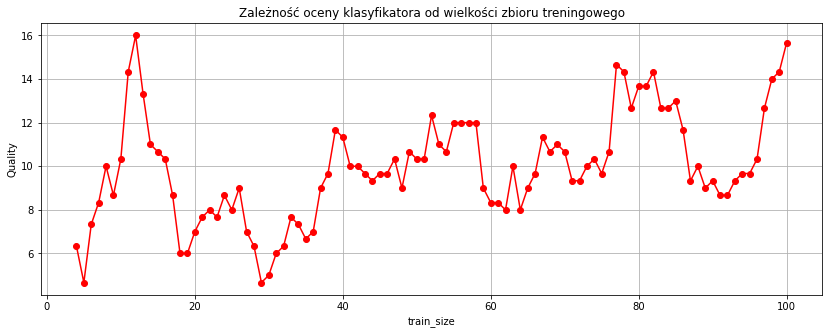

12


In [9]:
database = create_database([optimal_n_mfcc], 120)
optimal_train_size = find_optimal_train_size(optimal_n_mfcc, range(4,101), database)
print(optimal_train_size)

Reading database...
K = 1


K = 2


K = 3


K = 4


K = 5


K = 6


K = 7


K = 8


K = 9


K = 10




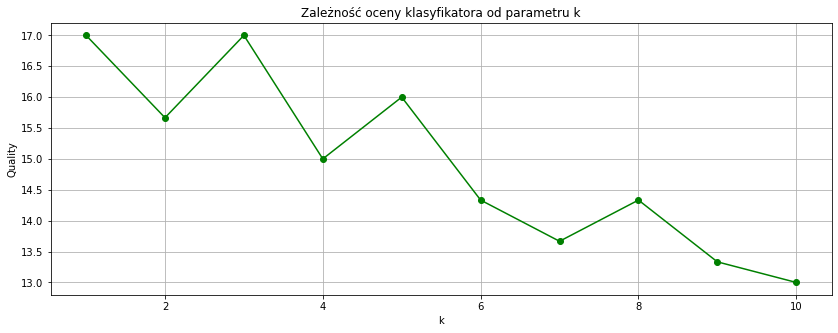

1


In [10]:
optimal_k = find_optimal_k(optimal_n_mfcc, optimal_train_size, range(1,11), database)
print(optimal_k)

In [11]:
print(f'Optimal n_mfcc: {optimal_n_mfcc}\nOptimal train_size: {optimal_train_size}\nOptimal k: {optimal_k}')

Optimal n_mfcc: 9
Optimal train_size: 12
Optimal k: 1


In [31]:
check_quality(optimal_n_mfcc, optimal_train_size, optimal_k, database)

Reading database...


17.0